### Intro
This notebook builds a joint distribution model between two variables:
1. Daily Average Base Fee
2. Daily Total Gas Used

DailyTotalGas can be interpreted as a demand signal for block space over the course of the day. This is in units of Gas.  To convert to units of FIL, we need base_fee.  base_fee is a parameter that evolves epoch to epoch, but in this notebook, we want to explore at the time-scale of days. We therefore aggregate base_fee into a day, by averaging the base_fee over the day.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pystarboard.data_spacescope as dss
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import numpy.random

import gas_models
import seaborn as sns
import matplotlib.pyplot as plt

import pyvinecopulib as pv
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter
from statsmodels.tsa.arima.model import ARIMA

from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy as sqa
from functools import reduce

In [3]:
auth='/Users/kiran/code/auth/kiran_spacescope_auth.json'
sso = dss.SpacescopeDataConnection(auth)

In [4]:
def get_basefee_spacescope(start_date, end_date):
    url_template = "https://api.spacescope.io/v2/gas/network_base_fee?end_hour=%s&start_hour=%s"
    dates_chunked = sso.chunk_dates(start_date, end_date, chunks_days=30)
    df_list = []
    for d in dates_chunked:
        dt_start = datetime.combine(d[0], datetime.min.time())
        dt_end = datetime.combine(d[1], datetime.max.time())
        chunk_start = dt_start.strftime("%Y-%m-%dT%H:%M:%SZ")
        chunk_end = dt_end.strftime("%Y-%m-%dT%H:%M:%SZ")
        
        url = url_template % (chunk_end, chunk_start)
        df = sso.spacescope_query_to_df(url)
        df_list.append(df)
    df_all = pd.concat(df_list, ignore_index=True)
    df_all['hour_date'] = pd.to_datetime(df_all['hour_date'])
    return df_all

In [5]:
# for modeling base-fee to total-gas-usage, we can use more data for training than learning the PSD
# gas usage b/c we want to create a general mapping between basefee and total-gas-usage, regardless
# of message type
# training_start_date = date(2021, 4, 1)
training_start_date = date(2021, 12, 1)
training_end_date = date.today()-timedelta(days=3)
df_basefee = get_basefee_spacescope(training_start_date, training_end_date)

In [112]:
df_basefee.describe()

,base_fee
count,2.322420e+05
mean,1.242163e-10
std,1.629776e-10
min,1.000000e-16
25%,3.900077e-12
50%,6.156362e-11
75%,1.914477e-10
max,2.551471e-09


In [7]:
df_basefee_daily = df_basefee.groupby(df_basefee['hour_date'].dt.date).mean()

Text(0.5, 0.98, 'Histogram')

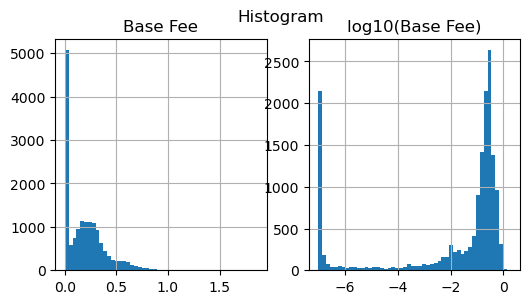

In [8]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
df_basefee['unit_base_fee'].hist(bins=50)
plt.title('Base Fee')
plt.subplot(1,2,2)
np.log10(df_basefee['unit_base_fee']).hist(bins=50)
plt.title('log10(Base Fee)')
plt.suptitle('Histogram')

In [9]:
gas_train_df = gas_models.get_training_data(training_start_date, training_end_date)

In [10]:
gas_train_df.head()

,stat_date,total_gas_used,provecommit_sector_gas_used,precommit_sector_gas_used,provecommit_aggregate_gas_used,precommit_sector_batch_gas_used,publish_storage_deals_gas_used,submit_windowed_post_gas_used,date,day_onboarded_rb_power_pib,...,total_raw_power_eib,total_qa_power_eib,rb_renewal_rate,day_renewed_qa_power_pib,day_renewed_rb_power_pib,fpr,day_onboarded_deal_power,network_qa_rb_ratio,precommitx_sector_gas_used,provecommitx_sector_gas_used
0,2021-12-01T00:00:00Z,45701291838974,34625228864896,9021529389232,42268692520,10721474671,177156219582,1758017073159,2021-12-01,25.611145,...,13.836309,13.863233,0.377308,1.595337,1.595337,0.021849,0.063563,1.001946,9032250863903,34667497557416
1,2021-12-02T00:00:00Z,46145178624812,34669035079924,9445493731124,53979339880,33261001597,133179730066,1743491144578,2021-12-02,25.051392,...,13.862410,13.889444,0.415555,1.553894,1.553894,0.027202,0.077832,1.001950,9478754732721,34723014419804
2,2021-12-03T00:00:00Z,46741380692315,35146980874547,9550262628534,50232094728,39523491378,175208316900,1697632682448,2021-12-03,25.134460,...,13.891214,13.919303,0.486349,1.990295,1.990295,0.022339,0.063811,1.002022,9589786119912,35197212969275
3,2021-12-04T00:00:00Z,45861351038506,34750381937412,9110026349288,51310120141,37798846193,149066711620,1682969648126,2021-12-04,24.865631,...,13.917158,13.945822,0.498766,2.221006,2.220886,0.022880,0.064695,1.002060,9147825195481,34801692057553
4,2021-12-05T00:00:00Z,44988145477249,33838799266570,9156860463168,53741411041,35280198495,165318743998,1657747184955,2021-12-05,24.324585,...,13.906805,13.935204,0.427935,1.909058,1.909058,0.020185,0.055678,1.002042,9192140661663,33892540677611


In [11]:
# aggregate base-fee to daily
print(len(df_basefee_daily), len(gas_train_df))
train_df = pd.DataFrame()
train_df['daily_base_fee'] = df_basefee_daily['unit_base_fee'].values
train_df['total_gas_used'] = gas_train_df['total_gas_used'].values

657 657


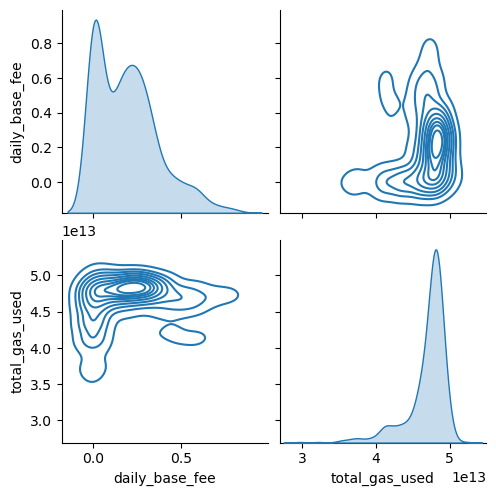

In [12]:
sns.pairplot(train_df, kind='kde')

### Copula Modeling
In this section, we build a copula model for modeling the joint distribution of a) daily_avg_base_fee and b) daily_sum_total_gas_used.
The steps are:
1. Convert the data to [pseudo-observations](https://search.r-project.org/CRAN/refmans/copula/html/pobs.html)
2. Fit a bivariate copula to the pseudo-observations. Although many parametric forms of bivariate copulas exist, we don't specify the form here and let *pyvinecopulib* determine the best family.
3. We can do an eye-test of model fit, by plotting the original data, and simulated data from the copula, in the pseudo-observation space. Here, we see that the model seems to fit the data well.

In [13]:
X = train_df[['daily_base_fee', 'total_gas_used']]
U = pv.to_pseudo_obs(X)

In [14]:
cop = pv.Bicop(data=U)
print(cop)

<pyvinecopulib.Bicop>
TLL, parameters = [30x30 grid]


In [15]:
V = cop.simulate(len(U))

Text(0.5, 1.0, 'Copula Model for DailyBaseFee & TotalGasUsed')

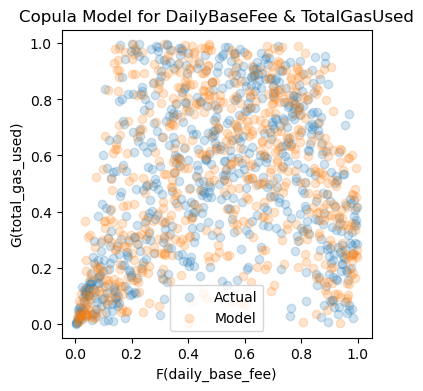

In [16]:
plt.figure(figsize=(4,4))
plt.scatter(U[:,0], U[:,1], alpha=0.2, label='Actual')
plt.scatter(V[:,0], V[:,1], alpha=0.2, label='Model')
plt.xlabel('F(daily_base_fee)')
plt.ylabel('G(total_gas_used)')
plt.legend()
plt.title('Copula Model for DailyBaseFee & TotalGasUsed')

### Generating conditional densities
The copula models the joint density: `H(base_fee, total_gas_used) = C(F(base_fee), G(total_gas_used))`
- `C` is the copula function
- `F` is the CDF of the `base_fee`
- `G` is the CDF of `total_gas_used`
- `H` is the multivariate CDF of `base_fee` and `total_gas_used`
From this copula model, we would like to get samples from the conditional distribution: `p(base_fee | total_gas_used)`

Let us define:
- `U = F(base_fee)`
- `V = G(total_gas_used)`
- `h` is the PDF of the corresponding CDF `H`
- `c` is the corresponding copula density of the copula function `C`

Refer to [copula density](https://en.wikipedia.org/wiki/Copula_(probability_theory)#Mathematical_derivation_of_copula_density_function) for more information about mapping the copula function, `C`, to the copula density, `c`.

Using the relationship of copula density, we can get the desired conditional density as follows:
```
c(u,v) = f(x,y)/(f(x)*f(y))
c(u,v) * f(x) = f(x,y)/f(y)
==>
f(x|y) = c(u,v)*f(x)
==>
X = base_fee
Y = total_gas_used
```

We could extend this to the distribution function as well, to make sampling easier. However, there is a built-in function in `pyvinecopulib` that does this for you.  `hfunc1` and `hfunc2` compute the conditional distribution functions: `P(U2<=u2|U1=u1)` and `P(U1<=u1|U2=u2)`, respectively.  So we can use this directly. Note that `hfunc1` and `hfunc2` operate in the copula space, so we need to apply the inverse CDF of the marginal to get back to the original data space.

In [17]:
total_gasused_daily_density = sm.nonparametric.KDEUnivariate(X['total_gas_used'])
total_gasused_daily_density.fit()
basefee_daily_density = sm.nonparametric.KDEUnivariate(X['daily_base_fee'])
basefee_daily_density.fit()

total_gasused_daily_ECDF = ECDF(X['total_gas_used'])
basefee_ECDF = ECDF(X['daily_base_fee'])

Text(0.5, 1.0, 'P(U<u|GasUsed)')

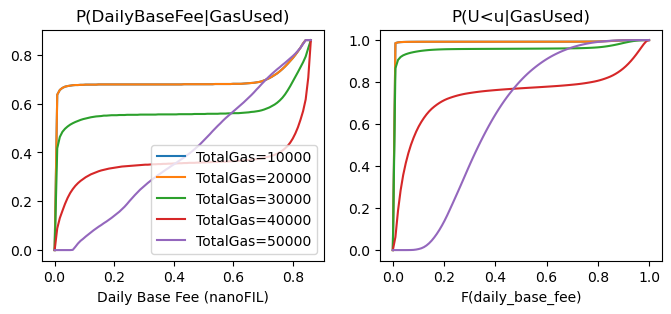

In [306]:
gasused_vec = np.arange(10000, 50000+10000, 10000)*1e9
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

basefee_lo = min(X['daily_base_fee'])/8
basefee_hi = max(X['daily_base_fee']) + np.median(X['daily_base_fee'])/4
xx = np.linspace(basefee_lo, basefee_hi, len(basefee_daily_density.cdf))
uu = basefee_daily_density.cdf

for g in gasused_vec:
    base_fee_vec = np.linspace(basefee_lo, basefee_hi, 100)
    # u = basefee_ECDF(base_fee_vec)
    u = np.linspace(0,1,100)
    v = total_gasused_daily_ECDF(g)
    
    v *= np.ones_like(u)
    U = np.vstack([u,v]).T
    conditional_copula_cdf = cop.hfunc2(U)
    # convert the conditional cdf to the non-pseudoobs space
    F_cdf = np.zeros_like(conditional_copula_cdf)
    for ii, k in enumerate(conditional_copula_cdf):
        best_idx = np.argmin(np.abs(uu-k))
        F_cdf[ii] = xx[best_idx]

    ax[0].plot(base_fee_vec, F_cdf, label='TotalGas=%d' % (g//1e9,))
    ax[1].plot(u, conditional_copula_cdf, label='TotalGas=%d' % (g//1e9,))

ax[0].legend()
ax[0].set_xlabel('Daily Base Fee (nanoFIL)')
ax[0].set_title('P(DailyBaseFee|GasUsed)')
# ax[0].set_xscale('log')

# ax[1].legend()
ax[1].set_xlabel('F(daily_base_fee)')
ax[1].set_title('P(U<u|GasUsed)')

### Sampling from Conditional Densities for Monte-Carlo Simulations
We use the [Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling#The_method) method for generating samples from the conditional distributions.

U ~ Unif(0,1)
draw u from U
x = F^{-1}(u)

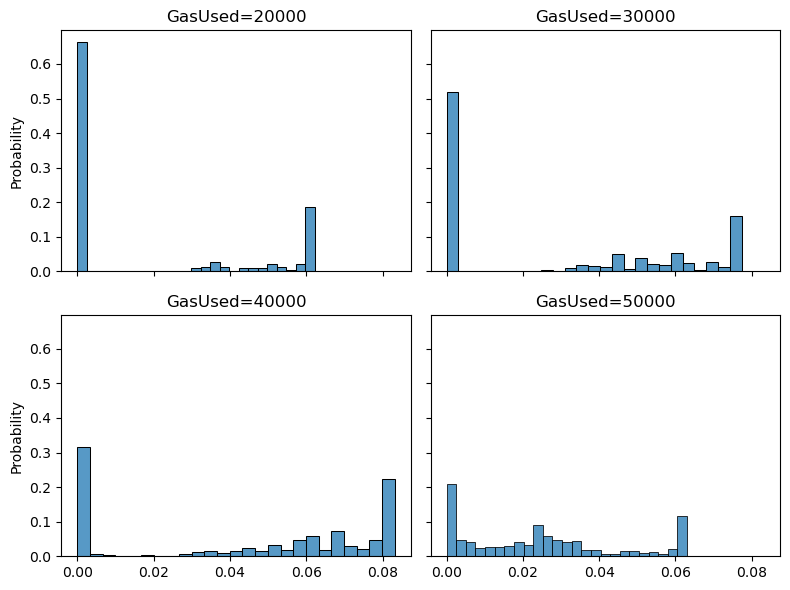

In [19]:
# gasused_vec = np.arange(35000, 50000+5000, 5000)*1e9
gasused_vec = np.asarray([20000, 30000, 40000, 50000])*1e9
nsamp = 500
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8,6))
for kk, g in enumerate(gasused_vec):
    base_fee_vec = np.linspace(min(X['daily_base_fee']), max(X['daily_base_fee']), 100)
    u = basefee_ECDF(base_fee_vec)
    v = total_gasused_daily_ECDF(g)
    
    v *= np.ones_like(u)
    U = np.vstack([u,v]).T
    conditional_copula_cdf = cop.hfunc2(U)
    # convert the conditional cdf to the non-pseudoobs space
    F_cdf = np.zeros_like(conditional_copula_cdf)
    for ii, k in enumerate(conditional_copula_cdf):
        best_idx = np.argmin(np.abs(uu-k))
        F_cdf[ii] = xx[best_idx]

    samps_vec = []
    for jj in range(nsamp):
        u = np.random.rand()
        best_idx = np.argmin(np.abs(F_cdf-u))
        samps_vec.append(xx[best_idx])

    ix,iy = np.unravel_index(kk, (2,2))
    sns.histplot(samps_vec, stat='probability', ax=ax[ix][iy], bins=25)
    ax[ix][iy].set_title('GasUsed=%d' % (g//1e9,))

plt.tight_layout()

<Axes: xlabel='total_gas_used', ylabel='Count'>

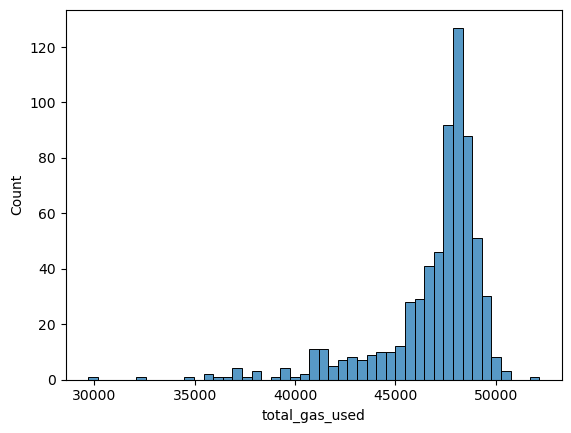

In [20]:
# investigate how base fee changes in low-gas regimes
# if DirectFIL+ will reduce PSD by 85%, lets approximate that total gas usage will go from
# 50k Gas Units to 50*0.2 = 10k GasUnits
# Do we have a lot of data in the 10k Gas Units, to approximate base-fee fluctuating around there?
# According to the histogram below, we have no data points in that low gas use regime.

plt.figure()
sns.histplot(X['total_gas_used']/1e9)

## Notes on dataset

May need a different model for low total-gas regimes to estimate base-fee more accurately
one way to do this is to generate synthetic data using MC techniques for total-gas with updates, and use that to a) train a secondary model for low-gas regimes, or b) augment the data to the original dataset and learn one model. 

This as a template: https://hackmd.io/5lcDIN23SJOrWrwy8f4Hpg

In [30]:
def get_message_gas_economy_lily(HEIGHT=3_000_000, auth='/Users/kiran/code/auth/lily.txt'):
    FILECOIN_GENESIS_UNIX_EPOCH = 1598306400
    with open(auth) as f:
        secretString = f.read()
    
    # Try to create a connection to the database
    try:
        # Define an engine using the connection string
        engine = sqa.create_engine(secretString)
        # Establish a connection to the database
        conn = engine.connect()
    # If the connection fails, catch the exception and print an error message
    except Exception as e:
        print("Failed to connect to database")
        # Propagate the error further
        raise(e)
        
    Q = f'''
         SELECT height, base_fee
         FROM "visor"."message_gas_economy"
         WHERE height > {HEIGHT}
         ORDER BY height ASC
     '''
    df_basefee = pd.read_sql(sql=sqa.text(Q), con=conn)
    df_basefee['time'] = pd.to_datetime(df_basefee['height'].values*30 + FILECOIN_GENESIS_UNIX_EPOCH, unit='s')
    
    return df_basefee

In [234]:
df_basefee = get_message_gas_economy_lily(HEIGHT=3_000_000)

In [235]:
df_basefee=df_basefee.sort_values(by='height')
df_basefee=df_basefee.set_index('height')
firstBlock=df_basefee.index[0]
lastBlock=df_basefee.index[-1]

In [236]:
diffBase=np.concatenate([[0.],np.diff(df_basefee['base_fee'])])
G_tilde=8*diffBase/df_basefee['base_fee']

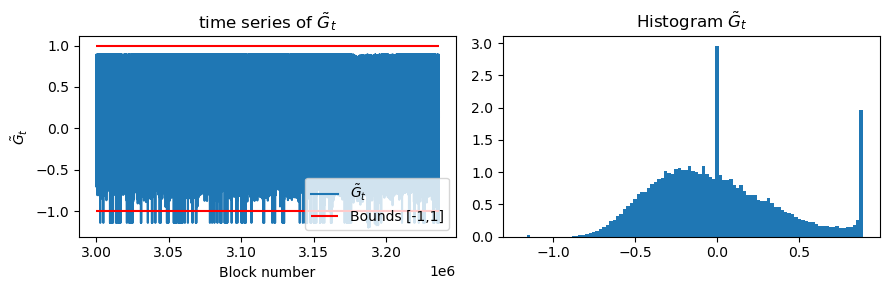

In [237]:
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.plot(G_tilde)
plt.hlines(-1,xmin=firstBlock,xmax=lastBlock,color='r')
plt.hlines(1,xmin=firstBlock,xmax=lastBlock,color='r')
plt.title(r'time series of $\tilde{G}_t$')
plt.ylabel(r'$\tilde{G}_t$')
plt.xlabel(r'Block number')
plt.legend([r'$\tilde{G}_t$','Bounds [-1,1]'])
plt.subplot(122)
plt.hist(G_tilde,bins=100,density=True)
plt.title(r'Histogram $\tilde{G}_t$')
plt.tight_layout()
plt.show()

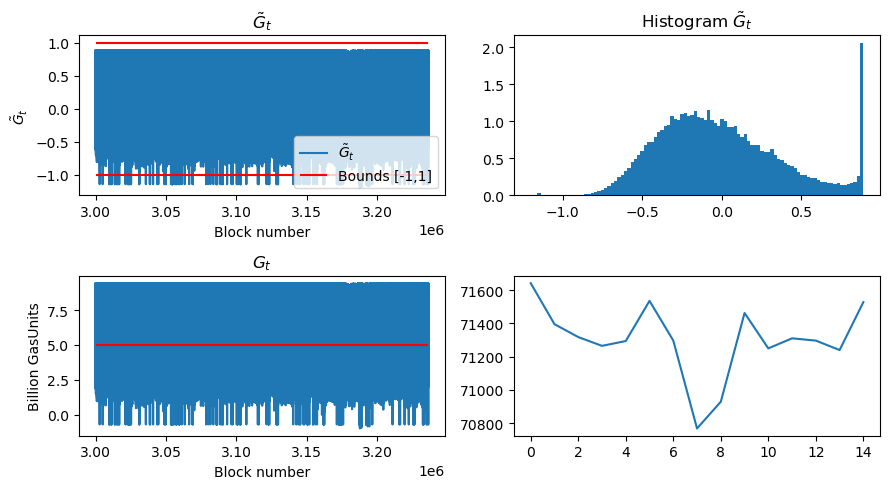

In [239]:
# clean the data
THRESHOLD=20  # larger threshold means less filtering
Gstar = 5e9
G_tilde_original=np.copy(G_tilde)
G_tilde=G_tilde[G_tilde!=0]
G_tilde=G_tilde[np.abs(G_tilde)<THRESHOLD]
Gt = G_tilde*Gstar + Gstar

plt.figure(figsize=(9,5))

plt.subplot(221)
plt.plot(G_tilde)
plt.hlines(-1,xmin=firstBlock,xmax=lastBlock,color='r')
plt.hlines(1,xmin=firstBlock,xmax=lastBlock,color='r')
plt.title(r'$\tilde{G}_t$')
plt.ylabel(r'$\tilde{G}_t$')
plt.xlabel(r'Block number')
plt.legend([r'$\tilde{G}_t$','Bounds [-1,1]'])

plt.subplot(222)
plt.hist(G_tilde,bins=100,density=True)
plt.title(r'Histogram $\tilde{G}_t$')

plt.subplot(223)
plt.plot(Gt/1e9)
plt.hlines(Gstar/1e9,xmin=firstBlock,xmax=lastBlock,color='r')
plt.title(r'$G_t$')
plt.ylabel('Billion GasUnits')
plt.xlabel(r'Block number')

# plot total gas usage by day
plt.subplot(224)
NUM_BLOCKS_PER_EPOCH = 5
NUM_EPOCHS_PER_DAY = 2880
aggregation_size = int(NUM_BLOCKS_PER_EPOCH*NUM_EPOCHS_PER_DAY)
Gt_daily = Gt[0:len(Gt)//aggregation_size*aggregation_size].values
Gt_daily = Gt_daily.reshape(aggregation_size,-1).sum(axis=0)
plt.plot(Gt_daily/1e9)

plt.tight_layout()
plt.show()

In [39]:
print(len(G_tilde))

222571


In [40]:
# with this cleaned data of Gtilde, we can train a generative model for Gtilde.
# simulate low gas regimes like-so.
# total gas reduction, lets say is 75%. Then, Gtilde will also be reduced by that amount.
# simulate Gtilde w/ a model, scale by gas reduction.  Then, simulate base-fee evolution w/ that.
# create a paired data set of sum(Gas(day)), average(base_fee)
# augment this to the original dataset and train a new joint probability distribution model

#ARIMA with AR(1), 0 differences and no moving average
model = ARIMA(G_tilde, order=(1,0,0)) 
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               base_fee   No. Observations:               222571
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -103758.146
Date:                Thu, 21 Sep 2023   AIC                         207522.292
Time:                        12:24:53   BIC                         207553.231
Sample:                             0   HQIC                        207531.355
                             - 222571                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0091      0.001     -8.790      0.000      -0.011      -0.007
ar.L1          0.1218      0.002     58.046      0.000       0.118       0.126
sigma2         0.1487      0.001    286.830      0.0

In [42]:
model_fit.params

const    -0.009084
ar.L1     0.121766
sigma2    0.148743
dtype: float64

In [46]:
# convert ARIMA model parameters to OU process parameters
alphaHat=model_fit.params[0]
phiHat=model_fit.params[1]

# QUESTION: do we use this or do we use sigma2 from the ARIMA estimation?
gammaHat2=np.var(G_tilde[1:]-alphaHat-phiHat*G_tilde[:-1])
h=1 # probably to be changed
thetaHat=-1./h*np.log(phiHat)
muHat=alphaHat/(1-phiHat)
sigmaHat2=(-2./h)*(gammaHat2/(1-phiHat**2))*np.log(phiHat)
sigmaHat=sigmaHat2**0.5
sd=((0.5*sigmaHat2/thetaHat)*(1-np.exp(-2*thetaHat*h)))**0.5
#prints the results
print('OU process parameters: theta=%0.02f mu=%0.02f sigma=%0.02f' % (thetaHat, muHat, sigmaHat))

OU process parameters: theta=2.11 mu=-0.01 sigma=0.71


(array([229.,  83., 110., 106.,  51.,  27.,  22.,  18.,   6.,   5.]),
 array([1.01729149e-07, 8.15811047e-02, 1.63162108e-01, 2.44743111e-01,
        3.26324113e-01, 4.07905116e-01, 4.89486119e-01, 5.71067122e-01,
        6.52648125e-01, 7.34229128e-01, 8.15810131e-01]),
 <BarContainer object of 10 artists>)

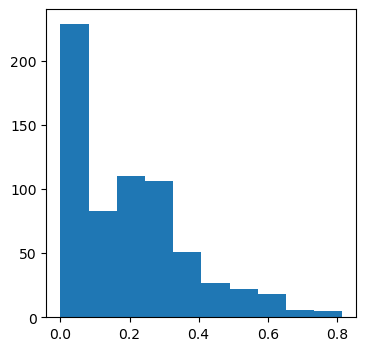

In [137]:
plt.figure(figsize=(4,4))
plt.hist(train_df['daily_base_fee'])

In [287]:
# using the process parameters, we can generate MC realizations of G_tilde
# next, we convert the G_tilde to G_t using the relationship: G_tilda = (Gt - G*)/G*
# then, we scale Gt to lower values that we don't have data for
# then, we simulate base_fee evolution w/ the time-series of Gt

def generate_augmented_dataset(ndays_per_realization=1, nsamps_per_scaling=10, gtilde_offset_vec=None):
    if ndays_per_realization < 1:
        print('min(ndays_per_realization) must be 1 - forcing to 1 before simulating!')
        ndays_per_realization = 1
    if gtilde_offset_vec is None:
        gtilde_offset_vec = np.asarray([0.25, 0.5, 0.75, 1.0])
    epochs_per_day = 2880
    blocks_per_epoch = 5
    blocks_per_day = blocks_per_epoch * epochs_per_day
    Gstar=5e9  # target block size

    gtilde = []
    total_gas_day = []
    base_fee_avg_day = []
    raw_basefee_vec = []
    for ii, gtilde_offset in enumerate(gtilde_offset_vec):
        for jj in range(nsamps_per_scaling):
            niter_per_loop = int(blocks_per_day*ndays_per_realization)
            
            G_tilde_vec = np.zeros(niter_per_loop+1)
            basefee_vec = np.zeros_like(G_tilde_vec)
            # choose random values for this
            random_idx = np.random.randint(len(train_df))
            basefee_vec[0] = train_df['daily_base_fee'].iloc[random_idx]  # this df is already in units of nanoFIL
            basefee_vec[1] = basefee_vec[0]  # this is consistent w/ JP, but technically, it should be evolved by 1 epoch?
            G_tilde_vec[0] = 8*diffBase[random_idx]/basefee_vec[0]  # diffBase is defined above
            
            for n in range(1,niter_per_loop):
                g_tilde_sample = G_tilde_vec[n-1]*np.exp(-thetaHat*h)+muHat*(1-np.exp(-thetaHat*h)) +sd*np.random.standard_normal()
                g_tilde_scaled = np.clip((g_tilde_sample - gtilde_offset)/2, -1, 1)  # offsets in the negative direction to simulate base-fee w/ reduced gas usage
                G_tilde_vec[n] = g_tilde_scaled

                # this simulates that all blocks within the same epoch have the same base-fee, which I think makes sense.
                # however, double check w/ JP
                if n % 5 == 0:
                    basefee_vec[n+1]=max(basefee_vec[n]*(1+G_tilde_vec[n]/8), 100*1e-18) # max for ensuring base_fee doesn't go to 0
                else:
                    basefee_vec[n+1] = basefee_vec[n]
    
            # now, aggregate G_tilde over each day, convert to Gt
            # aggregate base_fee over each day
            # store
            G_total = G_tilde_vec*Gstar+Gstar  # convert from Gtilde to Gt
            total_gas_day_vec = G_total[1:].reshape(blocks_per_day,-1).sum(axis=0)
            base_fee_avg_day_vec = basefee_vec[1:].reshape(blocks_per_day,-1).mean(axis=0)
        
            # aggregate all realizations
            total_gas_day.append(total_gas_day_vec)
            base_fee_avg_day.append(base_fee_avg_day_vec)
            gtilde.append(G_tilde_vec)
            raw_basefee_vec.append(basefee_vec)
    return np.concatenate(total_gas_day), np.concatenate(base_fee_avg_day), np.concatenate(gtilde), np.concatenate(raw_basefee_vec)

In [299]:
total_gas_day, base_fee_avg_day, gtilde, raw_basefee_vec = generate_augmented_dataset(
    ndays_per_realization=1, 
    nsamps_per_scaling=30, 
    gtilde_offset_vec=np.asarray([1.0, 1.25, 1.5, 1.75])
)

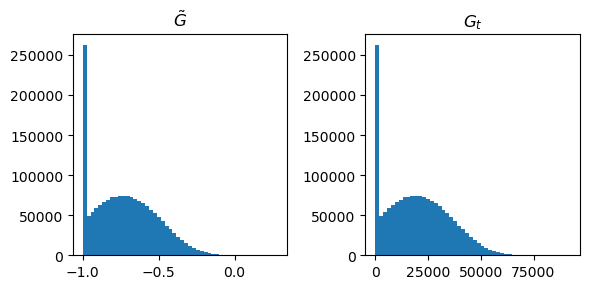

In [300]:
plt.figure(figsize=(6,3))

plt.subplot(121)
plt.hist(gtilde,bins=50)
plt.title(r'$\tilde{G}$')

plt.subplot(122)
plt.hist((gtilde*5e9+5e9)*2880*5/1e9,bins=50)
plt.title(r'$G_t$')

plt.tight_layout()

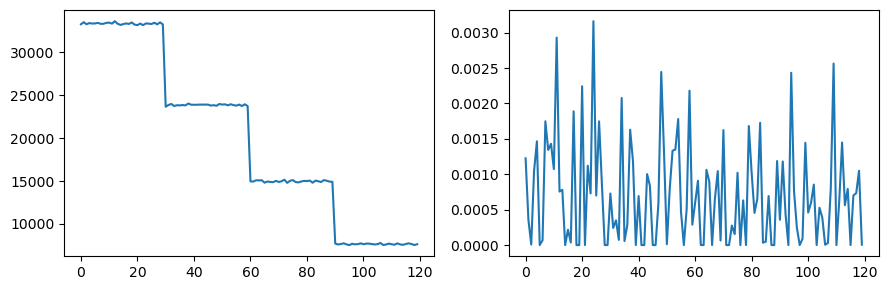

In [301]:
plt.figure(figsize=(9,3))

plt.subplot(121)
plt.plot(total_gas_day/1e9)

plt.subplot(122)
plt.plot(base_fee_avg_day)

plt.tight_layout()

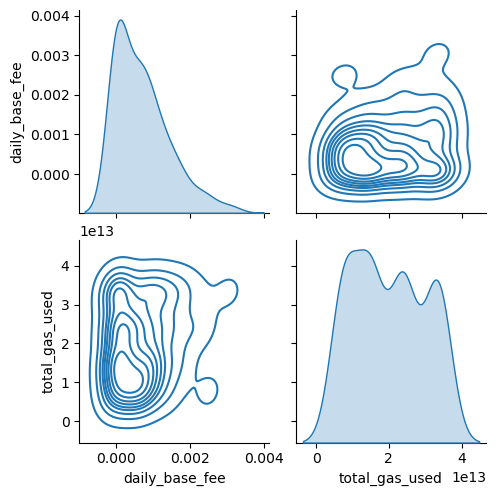

In [302]:
train_df_synthetic = pd.DataFrame()
train_df_synthetic['daily_base_fee'] = base_fee_avg_day
train_df_synthetic['total_gas_used'] = total_gas_day
sns.pairplot(train_df_synthetic, kind='kde')

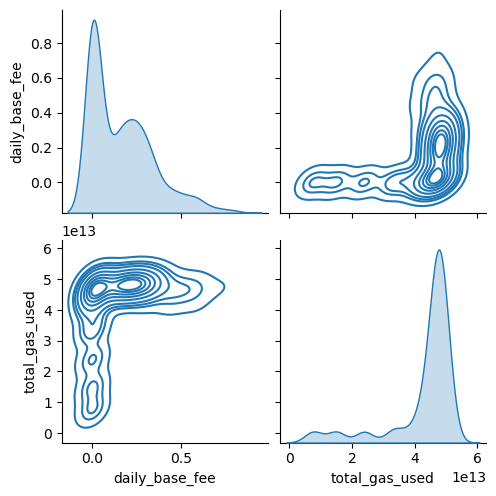

In [303]:
# combine synthetic & real training data
train_df['type'] = 'real'
train_df_synthetic['type'] = 'synthetic'
train_df_combined = pd.concat([train_df, train_df_synthetic], ignore_index=True)

sns.pairplot(train_df_combined, kind='kde')